In [ ]:
# default_exp data_augmentation

# Data augmentation

> This module focuses on having a set of classes to perform the needed data transformations.

Some of these transformations are already available in torchvision, for example:

`transforms.Resize, transforms.ToTensor(), transforms.Normalize(mean, std)`

In [93]:
#export
import numpy as np
import matplotlib.pyplot as plt

import cv2

from torchvision import transforms
from skimage import io, transform

from actions_in_videos.dataset_ucf101 import UCF101
from actions_in_videos.avi import AVI

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
#export
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']        
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        # for some reason the cv2.resize call fails when used in a DataLoader
            
        return {'image': img, 'label': label}

In [96]:
#export
class RandomCrop(object):
    """Crop randomly the image in a sample.
    NOTE: Output does not keep the same aspect ratio.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.            
    """

    def __init__(self, out_ratio=0.7, p_crop=0.5):
        self.out_ratio = out_ratio
        self.p_crop = p_crop
        
    def __call__(self, sample):        
        image, label = sample['image'], sample['label']

        curr_h, curr_w = image.shape[:2]
        
        resize_factor_w = (1-self.out_ratio)*np.random.rand()+self.out_ratio
        resize_factor_h = (1-self.out_ratio)*np.random.rand()+self.out_ratio
        w1 = int(curr_w*resize_factor_w)
        h1 = int(curr_h*resize_factor_h)
        w = np.random.randint(curr_w-w1)
        h = np.random.randint(curr_h-h1)
                
        # crop
        if np.random.uniform() <= self.p_crop:
            image = image[h:(h+h1),w:(w+w1),:]

        return {'image': image, 'label': label}

In [97]:
#export
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if type(label) != np.ndarray:
            label = np.ndarray(label)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [98]:
#export
class Normalize(object):
    """Normalises an image.
        
    Args:
        mean and std values. Deafult values based on the default pytorch 
        pretrained ResNet-50 model.      
        
        old values: 
        - mean: np.asarray([0.485, 0.456, 0.406]
        - std : np.asarray([0.229, 0.224, 0.225]
    """

    def __init__(self, mean = np.asarray([0.433, 0.4045, 0.3776], np.float32),
                       std  = np.asarray([0.1519876, 0.14855877, 0.156976], np.float32)):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        ## resnet model was trained on images with mean subtracted
        image = image/255.0
        
        return {'image': (image - self.mean)/self.std,
                'label': label}

In [99]:
#export
class RandomHorizontalFlip(object):
    """Randomly horizontally flip the image in a sample.  
    
    Args: prob of flipping the sample
    """
    def __init__(self, p_flip = .5):
        self.p = p_flip

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if np.random.uniform() <= self.p:
            image = cv2.flip(image, 1)  # one is horizontally                   
        
        return {'image': image, 'label': label}
    

In [100]:
#export
class AddRandomBrightness(object):
    """Randomly add brightness between a minimum and maximum value.
    Saturates if needed. """
    
    def __init__(self, b_offset = 15):
        self.brightness = b_offset*2  # brightness +/- b_offset
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        image += np.random.randint(self.brightness+1) - self.brightness/2.0
        
        #saturates:
        image[image>255] = 255.0
        image[image<0]   = 0.0
        
        return {'image': image, 'label': label}

Here is how the classes work:

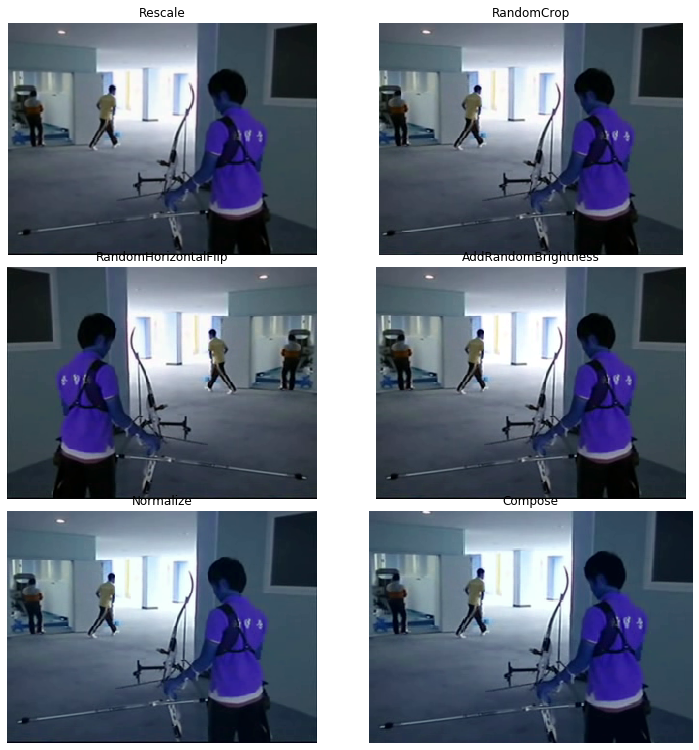

In [114]:
scale = Rescale(224)
crop = RandomCrop(p_crop=1.0)
flip = RandomHorizontalFlip(p_flip=1.0)
brightness = AddRandomBrightness(15)
normalize = Normalize()

composed = transforms.Compose([RandomCrop(out_ratio=0.7, p_crop=0.5),
                               RandomHorizontalFlip(0.5),
                               Rescale(224),
                               AddRandomBrightness(15),                               
                               Normalize()])

tsmf_list = [scale, crop, flip, brightness, normalize, composed]


# read the data
ucf = UCF101('../data/UCF101/')

X, class_names = ucf.getFileList(data_type='train')
file_list, labels = X[0], X[1]

avi = AVI(file_list[200])
label = labels[200]

# Apply each of the above transforms on sample.
sample = {'image': avi.getRandomFrame(),
          'label': label}

# plot after applying the transformations
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i, tsfrm in enumerate(tsmf_list):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(np.ceil(len(tsmf_list)/2), 2, i + 1)
    ax.set_title(type(tsfrm).__name__)
    ax.axis('off')
    avi.frameShow(transformed_sample['image'])



# fin